# AWS

## ssh / scp

## jupyterへのアクセス

## vscodeで編集

## jupyterを使ったfileのダウンロード, アップロード

# 時系列分析

## 概論

## ARモデル

In [ ]:
# 自己相関プロットを入れる

In [1]:
# 偏自己相関プロット

## ARMAモデル

## ARIMAモデル

## (一般化)状態空間モデル

ARMAモデルは状態空間モデルで表現できる

予測, フィルタリング, 平滑化

MCMC

SMC

### Stanの使い方

#### データセット作成

In [4]:
import pystan # Stanのpythonラッパー
import numpy as np # 計算
import matplotlib.pyplot as plt # 図表描画
%matplotlib inline

plt.style.use('seaborn-darkgrid') # お好みで灰色テーマに。必要はない。

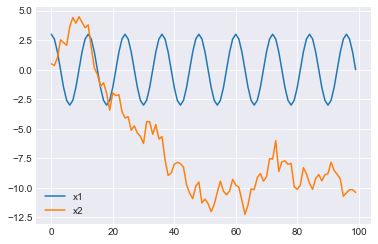

In [10]:
x1 = np.cos(2 * np.pi * np.arange(100) / 12) * 3 # 周期成分

np.random.seed(seed=42) # 疑似乱数の種を固定
x2 = np.cumsum(np.random.randn(100)) # ランダムウォーク成分
x3 = x1 + x2 
plt.plot(x1, label="x1")
plt.plot(x2, label="x2")
plt.legend()

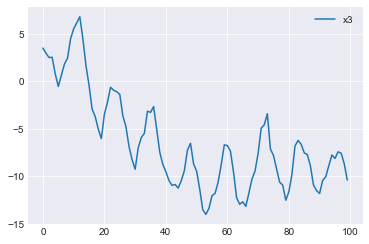

In [11]:
plt.plot(x3, label="x3")
plt.legend()

#### 周期 + 1次のトレンドモデル

- "20190530_randomwalk_cycle.stan"として、以下のコードを保存。  
    - ちなみにvisual studio codeであれば、"stan-vscode"という拡張機能を入れると、構文ハイライトができる。

```
data {
  int<lower=1> n;
  int<lower=1> m;
  vector[n] y;
}
parameters {
  vector[n] mu;
  vector[n] seasonal;
  real<lower=0> sigma_level;
  real<lower=0> sigma_seas;
  real<lower=0> sigma_irreg;
}
transformed parameters {
  vector[n] yhat;
  yhat = mu + seasonal;
}
model {
  for(t in 12:n)
    seasonal[t] ~ normal(- sum(seasonal[t-11:t-1]), sigma_seas);

  for(t in 2:n)
    mu[t] ~ normal(mu[t-1], sigma_level);

  y ~ normal(yhat, sigma_irreg);
}

generated quantities {
    vector[n + m] seasonal_pred;
    vector[n + m] mu_pred;
    vector[m] y_pred;
    seasonal_pred[1:n] = seasonal;
    mu_pred[1:n] = mu;

    for (t in 1:m) {
        seasonal_pred[n+t] = normal_rng(- sum(seasonal_pred[(n+t-11):(n+t-1)]), sigma_seas);
        mu_pred[n+t] = normal_rng(mu_pred[n+t-1], sigma_level);
        y_pred[t] = normal_rng(mu_pred[n+t] + seasonal_pred[n+t], sigma_irreg);
    }
    
}
```

In [ ]:
dat = {"y": x3,
      "n": len(x3),
      "m":20}

sm = pystan.StanModel(model_code=model)
fit = sm.sampling(data=dat, iter=1000, chains=4)

In [ ]:
print(fit)

In [ ]:
fit.plot()

In [ ]:
la = fit.extract(permuted=True, inc_warmup=False)  # return a dictionary of arrays

level = la["mu"].mean(axis=0)
cycle = la["seasonal"].mean(axis=0)

plt.plot(level, label="level")
plt.plot(cycle, label="cycle")
plt.plot(x1, label="level_real")
plt.plot(x2, label="cycle_real")
plt.legend()

In [ ]:
level_pred = la["mu_pred"].mean(axis=0)
cycle_pred = la["seasonal_pred"].mean(axis=0)
 = la["y_pred"].mean(axis=0)

In [ ]:
level_pred[100:]

In [ ]:
plt.plot(np.arange(100,120), level_pred[100:], label="level_pred")
plt.plot(np.arange(100,120), cycle_pred[100:], label="cycle_pred")

In [ ]:
from itertools import chain
level_pred_flat = la["mu_pred"][:,100:].reshape(-1)
cycle_pred_flat = la["seasonal_pred"][:,100:].reshape(-1)
y_pred_flat = la["y_pred"].reshape(-1)
index_pred_flat = list(chain.from_iterable([list(range(100,120)) for i in range(2000)]))

In [ ]:
la["mu_pred"][0,100:]

In [ ]:
plt.plot(level, label="level")
plt.plot(cycle, label="cycle")
plt.plot(np.arange(100,120), level_pred[100:], label="level_pred")
plt.plot(np.arange(100,120), cycle_pred[100:], label="cycle_pred")
plt.plot(x1, label="level_real")
plt.plot(x2, label="cycle_real")
plt.legend()

In [ ]:
plt.plot(x1, label="level_real")
plt.plot(x2, label="cycle_real")
plt.scatter(index_pred_flat, level_pred_flat, label="sample_pred", alpha=0.01)
plt.plot(np.arange(100,120), level_pred[100:], label="level_pred")
plt.scatter(index_pred_flat, cycle_pred_flat, label="cycle_pred", alpha=0.01)
plt.plot(np.arange(100,120), cycle_pred[100:], label="cycle_pred")
plt.legend()

In [ ]:
plt.scatter(index_pred_flat, y_pred_flat, label="sample_pred", alpha=0.01)
plt.plot(np.arange(100,120), y_pred, label="y_pred")
plt.plot(np.arange(100), x3[:100], label="y")

#### 周期 + 二次のトレンドモデル

In [ ]:
model2 = """data {
  int<lower=1> n;
  int<lower=1> m;
  int<lower=1> c;
  vector[n] y;
}
parameters {
  vector[n] mu;
  vector[n] seasonal;
  real<lower=0> sigma_level;
  real<lower=0> sigma_seas;
  real<lower=0> sigma_irreg;
}
transformed parameters {
  vector[n] yhat;
  yhat = mu + seasonal;
}
model {
  for(t in c:n)
    seasonal[t] ~ normal(- sum(seasonal[(t-c+1):t-1]), sigma_seas);

  for(t in 3:n)
    mu[t] ~ normal(2 * mu[t-1] - mu[t-2], sigma_level);

  y ~ normal(yhat, sigma_irreg);
}

generated quantities {
    vector[n + m] seasonal_pred;
    vector[n + m] mu_pred;
    vector[m] y_pred;
    seasonal_pred[1:n] = seasonal;
    mu_pred[1:n] = mu;

    for (t in 1:m) {
        seasonal_pred[n+t] = normal_rng(- sum(seasonal_pred[(n+t-c+1):(n+t-1)]), sigma_seas);
        mu_pred[n+t] = normal_rng(2 * mu_pred[n+t-1] - mu_pred[n+t-2] , sigma_level);
        y_pred[t] = normal_rng(mu_pred[n+t] + seasonal_pred[n+t], sigma_irreg);
    }
    
}
"""

In [ ]:
%%time
sm2 = pystan.StanModel(model_code=model2)

In [ ]:
%%time
dat2 = {"y": x3,
      "n": len(x3),
      "m":20,
      "c":12}
fit2 = sm2.sampling(data=dat2, iter=1000, chains=4)

In [ ]:
print(fit2)

In [ ]:
la2 = fit2.extract(permuted=True, inc_warmup=False)  # return a dictionary of arrays
trend = la2["mu"].mean(axis=0)
cycle_2 = la2["seasonal"].mean(axis=0)

plt.plot(trend, label="level")
plt.plot(cycle_2, label="cycle")
plt.plot(x1, label="level_real")
plt.plot(x2, label="cycle_real")
plt.legend()

In [ ]:
plt.plot(trend, label="level")
plt.plot(cycle_2, label="cycle")
plt.legend()

#### 周期 + 三次のトレンドモデル

$((t - t_{-1}) - (t_{-1} - t_{-2})) -  ((t_{-1} - t_{-2}) - (t_{-2} - t_{-3})) = 0$

$t = 3t_{-1} - 3t_{-2} + t{_3}$

In [ ]:
model3 = """data {
  int<lower=1> n;
  int<lower=1> m;
  int<lower=1> c;
  vector[n] y;
}
parameters {
  vector[n] mu;
  vector[n] seasonal;
  real<lower=0> sigma_level;
  real<lower=0> sigma_seas;
  real<lower=0> sigma_irreg;
}
transformed parameters {
  vector[n] yhat;
  yhat = mu + seasonal;
}
model {
  for(t in c:n)
    seasonal[t] ~ normal(- sum(seasonal[(t-c+1):t-1]), sigma_seas);

  for(t in 4:n)
    mu[t] ~ normal(3 * mu[t-1] - 3 * mu[t-2] + mu[t-3], sigma_level);

  y ~ normal(yhat, sigma_irreg);
}

generated quantities {
    vector[n + m] seasonal_pred;
    vector[n + m] mu_pred;
    vector[m] y_pred;
    seasonal_pred[1:n] = seasonal;
    mu_pred[1:n] = mu;

    for (t in 1:m) {
        seasonal_pred[n+t] = normal_rng(- sum(seasonal_pred[(n+t-c+1):(n+t-1)]), sigma_seas);
        mu_pred[n+t] = normal_rng(3 * mu_pred[n+t-1] - 3 * mu_pred[n+t-2] + mu_pred[n+t-3], sigma_level);
        y_pred[t] = normal_rng(mu_pred[n+t] + seasonal_pred[n+t], sigma_irreg);
    }
    
}
"""

In [ ]:
%%time
sm3 = pystan.StanModel(model_code=model3)

In [ ]:
%%time
fit3 = sm3.sampling(data=dat2, iter=1000, chains=4)

In [ ]:
print(fit3)